# Healthcare Hack Nights: Part I

In [ ]:
## RNA-Seq
Questions that can be answered by RNA-seq:
    - What genes are differentially expressed between group samples?
    - How does gene expression change across time or conditions? (eg, in benign vs malignant tumors)
    - What pathways or processes are enriched under a condition?

In [151]:
%matplotlib inline

In [15]:
import pandas as pd

In [241]:
lihc = pd.read_csv('../lihc_rnaseq.csv')
lihc.set_index('bcr_patient_barcode', inplace=True)
lihc.shape

(423, 20531)

In this count matrix, each column represents an Ensembl gene transcript, each row a patient sequenced RNA library, and the values give the raw numbers of fragments that were uniquely assigned to the respective gene in each library. We also have additional information on each of the patients samples (the rows of the count matrix) and on each of the genes (the columns of the matrix).
                    
We now have all the ingredients to prepare our data object in a form that is suitable for analysis, namely:

 - countdata: a table with the fragment counts

 - rowdata: a table with information about the patient samples


In [18]:
lihc.head()

,bcr_patient_barcode,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,...,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,psiTPTE22|387590,tAKR|389932
0,TCGA-2V-A95S-01A-11R-A37K-07,0.0,1.5051,3.7074,90.1124,1017.1038,0.0,141.3911,0.6516,0.0000,...,24.7597,273.6602,794.2662,18.2440,499.1041,3172.5037,890.0472,510.1808,3.9094,6.5157
1,TCGA-2Y-A9GS-01A-12R-A38B-07,0.0,26.4120,2.6663,71.0054,639.2311,0.0,122.7206,1.4786,0.0000,...,68.5067,632.8241,1153.7703,71.4638,1000.4929,5301.1336,755.5446,860.5224,6.4071,482.9966
2,TCGA-2Y-A9GT-01A-11R-A38B-07,0.0,0.0000,4.4833,95.5122,742.4344,0.0,95.0460,1.7933,0.8967,...,46.6263,1219.4575,1133.3782,12.5532,1289.3970,3219.0092,860.7935,523.6494,14.3466,83.3894
3,TCGA-2Y-A9GU-01A-11R-A38B-07,0.0,5.7222,5.1216,61.6679,1186.9807,0.0,280.2709,0.8341,0.0000,...,18.3511,285.2758,1150.2786,9.1755,941.7437,3092.9899,1339.6283,343.6655,2.5024,2.5024
4,TCGA-2Y-A9GV-01A-11R-A38B-07,0.0,11.4975,5.4230,104.4670,878.1726,0.0,282.5719,0.0000,0.0000,...,41.4552,999.1540,1631.9797,4.2301,1380.7107,2902.7073,575.2961,665.8206,2.5381,119.2893


The dataset contains the number of counts for ~20k genes defined by their Entrez transcript ID x 423 deidentified patients. 

Entrez (https://www.ncbi.nlm.nih.gov/Web/Search/entrezfs.html) is a data retrieval system that provides users access to NCBI’s databases such as PubMed, GenBank, GEO, and many others. You can access Entrez from a web browser to manually enter queries, or you can use Biopython’s Bio.Entrez module for programmatic access to Entrez. 

Entrez gene IDs are unique gene identifiers that can be used to trace a particular gene or transcript to the genome.

In [19]:
# Get Entrez transcript IDs

ids = pd.Series(lihc.columns.values[1:]).apply(lambda x: x.split('|')[1]).values
ids[:5]

array(['100130426', '100133144', '100134869', '10357', '10431'],
      dtype=object)

# BioMart


In [2]:
from pybiomart import Server, Dataset

In [9]:
# Retrieving a dataset directly with known dataset name

dataset = Dataset(name='hsapiens_gene_ensembl',
                  host='http://www.ensembl.org')

dataset.query(
              filters={'chromosome_name': ['1','2']})

,Gene stable ID,Gene stable ID version,Transcript stable ID,Transcript stable ID version
0,ENSG00000200036,ENSG00000200036.1,ENST00000363166,ENST00000363166.1
1,ENSG00000252396,ENSG00000252396.1,ENST00000516587,ENST00000516587.1
2,ENSG00000252429,ENSG00000252429.2,ENST00000516620,ENST00000516620.2
3,ENSG00000221643,ENSG00000221643.1,ENST00000408716,ENST00000408716.1
4,ENSG00000264371,ENSG00000264371.1,ENST00000580572,ENST00000580572.1
...,...,...,...,...
36496,ENSG00000196290,ENSG00000196290.15,ENST00000409357,ENST00000409357.5
36497,ENSG00000196290,ENSG00000196290.15,ENST00000409129,ENST00000409129.2
36498,ENSG00000196290,ENSG00000196290.15,ENST00000409588,ENST00000409588.1
36499,ENSG00000196290,ENSG00000196290.15,ENST00000436412,ENST00000436412.1


The `attributes` attribute can be used to pull up a list of additional fields available from the dataset

In [7]:
list(dataset.attributes)

['ensembl_gene_id',
 'ensembl_gene_id_version',
 'ensembl_transcript_id',
 'ensembl_transcript_id_version',
 'ensembl_peptide_id',
 'ensembl_peptide_id_version',
 'ensembl_exon_id',
 'description',
 'chromosome_name',
 'start_position',
 'end_position',
 'strand',
 'band',
 'transcript_start',
 'transcript_end',
 'transcription_start_site',
 'transcript_length',
 'transcript_tsl',
 'transcript_gencode_basic',
 'transcript_appris',
 'transcript_mane_select',
 'external_gene_name',
 'external_gene_source',
 'external_transcript_name',
 'external_transcript_source_name',
 'transcript_count',
 'percentage_gene_gc_content',
 'gene_biotype',
 'transcript_biotype',
 'source',
 'transcript_source',
 'version',
 'transcript_version',
 'peptide_version',
 'phenotype_description',
 'Source_name',
 'study_external_id',
 'strain_name',
 'strain_gender',
 'p_value',
 'go_id',
 'name_1006',
 'definition_1006',
 'go_linkage_type',
 'namespace_1003',
 'goslim_goa_accession',
 'goslim_goa_description',


We can map the gene stable ID with the mappings from the to get a sense of which pathways are linked to a particular gene:

In [21]:
dataset.filters

{'link_so_mini_closure': <biomart.Filter name='link_so_mini_closure', type='list'>,
 'link_go_closure': <biomart.Filter name='link_go_closure', type='text'>,
 'link_ensembl_transcript_stable_id': <biomart.Filter name='link_ensembl_transcript_stable_id', type='text'>,
 'gene_id': <biomart.Filter name='gene_id', type='text'>,
 'transcript_id': <biomart.Filter name='transcript_id', type='text'>,
 'link_ensembl_gene_id': <biomart.Filter name='link_ensembl_gene_id', type='text'>,
 'chromosome_name': <biomart.Filter name='chromosome_name', type='text'>,
 'start': <biomart.Filter name='start', type='text'>,
 'end': <biomart.Filter name='end', type='text'>,
 'band_start': <biomart.Filter name='band_start', type='drop_down_basic_filter'>,
 'band_end': <biomart.Filter name='band_end', type='drop_down_basic_filter'>,
 'marker_start': <biomart.Filter name='marker_start', type='drop_down_basic_filter'>,
 'marker_end': <biomart.Filter name='marker_end', type=''>,
 'hsapiens_encode.type': <biomart.Fi

In [86]:
ensmbl_entrez_gene_ids = dataset.query(attributes=['ensembl_transcript_id', 'entrezgene_id'])
ensmbl_entrez_gene_ids.tail(10)

,Transcript stable ID,NCBI gene ID
251176,ENST00000644207,NaN
251177,ENST00000647544,NaN
251178,ENST00000642596,NaN
251179,ENST00000643537,NaN
251180,ENST00000644633,NaN
251181,ENST00000642800,NaN
251182,ENST00000645112,56169.0
251183,ENST00000642712,56169.0
251184,ENST00000646090,56169.0
251185,ENST00000643960,56169.0


In [88]:
ensmbl_entrez_gene_ids.dropna(inplace=True)
ensmbl_entrez_gene_ids['NCBI gene ID'] = ensmbl_entrez_gene_ids['NCBI gene ID'].astype(int)
ensmbl_entrez_gene_ids = ensmbl_entrez_gene_ids.set_index('NCBI gene ID').to_dict()['Transcript stable ID']
ensmbl_entrez_gene_ids

{4535: 'ENST00000361390',
 4536: 'ENST00000361453',
 4512: 'ENST00000361624',
 113219467: 'ENST00000387416',
 4513: 'ENST00000361739',
 4509: 'ENST00000361851',
 4508: 'ENST00000361899',
 4514: 'ENST00000362079',
 4537: 'ENST00000361227',
 4539: 'ENST00000361335',
 4538: 'ENST00000361381',
 4540: 'ENST00000361567',
 4541: 'ENST00000361681',
 4519: 'ENST00000361789',
 1028: 'ENST00000471157',
 51621: 'ENST00000616962',
 255027: 'ENST00000567442',
 9665: 'ENST00000549219',
 4849: 'ENST00000611667',
 102723475: 'ENST00000622690',
 9093: 'ENST00000431375',
 79165: 'ENST00000619669',
 57348: 'ENST00000423529',
 1113: 'ENST00000556876',
 5165: 'ENST00000493226',
 89927: 'ENST00000565913',
 94104: 'ENST00000464256',
 1007: 'ENST00000511822',
 147798: 'ENST00000620520',
 23532: 'ENST00000398741',
 338755: 'ENST00000338569',
 144125: 'ENST00000307401',
 54664: 'ENST00000462754',
 51277: 'ENST00000534855',
 440243: 'ENST00000612056',
 161725: 'ENST00000560598',
 2558: 'ENST00000400081',
 285148:

In [91]:
ensmbl_ids = pd.Series(lihc.columns.values[1:]).apply(lambda x: x.split('|')[1]).astype(int).map(ensmbl_entrez_gene_ids).dropna()

# Had to drop ~2k that didn't align, is there a better way?

In [80]:
dataset.filters

{'link_so_mini_closure': <biomart.Filter name='link_so_mini_closure', type='list'>,
 'link_go_closure': <biomart.Filter name='link_go_closure', type='text'>,
 'link_ensembl_transcript_stable_id': <biomart.Filter name='link_ensembl_transcript_stable_id', type='text'>,
 'gene_id': <biomart.Filter name='gene_id', type='text'>,
 'transcript_id': <biomart.Filter name='transcript_id', type='text'>,
 'link_ensembl_gene_id': <biomart.Filter name='link_ensembl_gene_id', type='text'>,
 'chromosome_name': <biomart.Filter name='chromosome_name', type='text'>,
 'start': <biomart.Filter name='start', type='text'>,
 'end': <biomart.Filter name='end', type='text'>,
 'band_start': <biomart.Filter name='band_start', type='drop_down_basic_filter'>,
 'band_end': <biomart.Filter name='band_end', type='drop_down_basic_filter'>,
 'marker_start': <biomart.Filter name='marker_start', type='drop_down_basic_filter'>,
 'marker_end': <biomart.Filter name='marker_end', type=''>,
 'hsapiens_encode.type': <biomart.Fi

In [96]:
# Find a faster way to do this

attributes = [
#     'gene_id',
    'entrezgene_id',
    'ensembl_gene_id',
    'ensembl_transcript_id',
    'go_id',
    'name_1006',
    'definition_1006',
    'go_linkage_type',
    'hgnc_id',
    'hgnc_symbol',
#     'hgnc_trans_name',
]
go_mappings = dataset.query(attributes=attributes)

In [97]:
go_mappings.to_csv('data/go_mappings.csv', index=False)

In [92]:
# Figure out better way to do this
attributes = [
#     'gene_id',
    'entrezgene_id',
    'ensembl_gene_id',
    'ensembl_transcript_id',
    'go_id',
    'name_1006',
    'definition_1006',
    'go_linkage_type',
    'hgnc_id',
    'hgnc_symbol',
#     'hgnc_trans_name',
]
dataset.query(attributes=attributes,
              filters={'transcript_id': ensmbl_ids.values}
             )

,NCBI gene ID,Gene stable ID,Transcript stable ID,GO term accession,GO term name,GO term definition,GO term evidence code,HGNC ID,HGNC symbol


## Examine Gene Counts



In [98]:
go_mappings = pd.read_csv('data/go_mappings.csv')

go_mappings.shape

/Users/mattheweng/Desktop/Galvanize/Projects/hacknights/env-tcga/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1392800, 9)

In [99]:
go_mappings.head()

,NCBI gene ID,Gene stable ID,Transcript stable ID,GO term accession,GO term name,GO term definition,GO term evidence code,HGNC ID,HGNC symbol
0,NaN,ENSG00000210049,ENST00000387314,NaN,NaN,NaN,NaN,HGNC:7481,MT-TF
1,NaN,ENSG00000211459,ENST00000389680,NaN,NaN,NaN,NaN,HGNC:7470,MT-RNR1
2,NaN,ENSG00000210077,ENST00000387342,NaN,NaN,NaN,NaN,HGNC:7500,MT-TV
3,NaN,ENSG00000210082,ENST00000387347,NaN,NaN,NaN,NaN,HGNC:7471,MT-RNR2
4,NaN,ENSG00000209082,ENST00000386347,NaN,NaN,NaN,NaN,HGNC:7490,MT-TL1


In [104]:
go_mappings.loc[~go_mappings['NCBI gene ID'].isnull()]

,NCBI gene ID,Gene stable ID,Transcript stable ID,GO term accession,GO term name,GO term definition,GO term evidence code,HGNC ID,HGNC symbol
5,4535,ENSG00000198888,ENST00000361390,GO:0016020,membrane,A lipid bilayer along with all the proteins an...,IEA,HGNC:7455,MT-ND1
6,4535,ENSG00000198888,ENST00000361390,GO:0016021,integral component of membrane,The component of a membrane consisting of the ...,IEA,HGNC:7455,MT-ND1
7,4535,ENSG00000198888,ENST00000361390,GO:0055114,oxidation-reduction process,A metabolic process that results in the remova...,IEA,HGNC:7455,MT-ND1
8,4535,ENSG00000198888,ENST00000361390,GO:0005743,mitochondrial inner membrane,"The inner, i.e. lumen-facing, lipid bilayer of...",IEA,HGNC:7455,MT-ND1
9,4535,ENSG00000198888,ENST00000361390,GO:0005739,mitochondrion,"A semiautonomous, self replicating organelle t...",IEA,HGNC:7455,MT-ND1
...,...,...,...,...,...,...,...,...,...
1392787,60678,ENSG00000284869,ENST00000646013,NaN,NaN,NaN,NaN,HGNC:24614,EEFSEC
1392796,56169,ENSG00000285114,ENST00000645112,NaN,NaN,NaN,NaN,HGNC:7151,GSDMC
1392797,56169,ENSG00000285114,ENST00000642712,NaN,NaN,NaN,NaN,HGNC:7151,GSDMC
1392798,56169,ENSG00000285114,ENST00000646090,NaN,NaN,NaN,NaN,HGNC:7151,GSDMC


In [284]:
# Create mapping of NCBI gene id to gene name/symbol

map_geneid_to_hfnc_symbol = go_mappings[['NCBI gene ID', 'HGNC symbol']] \
    .drop_duplicates() \
    .dropna()
# map_geneid_to_hfnc_symbol['NCBI gene ID'] = map_geneid_to_hfnc_symbol['NCBI gene ID'].astype(int)
map_geneid_to_hfnc_symbol = map_geneid_to_hfnc_symbol.set_index('NCBI gene ID') \
    .to_dict()['HGNC symbol']
map_geneid_to_hfnc_symbol

{'4535': 'MT-ND1',
 '4536': 'MT-ND2',
 '4512': 'MT-CO1',
 '113219467': 'MT-TS1',
 '4513': 'MT-CO2',
 '4509': 'MT-ATP8',
 '4508': 'MT-ATP6',
 '4514': 'MT-CO3',
 '4537': 'MT-ND3',
 '4539': 'MT-ND4L',
 '4538': 'MT-ND4',
 '4540': 'MT-ND5',
 '4541': 'MT-ND6',
 '4519': 'MT-CYB',
 '1028': 'CDKN1C',
 '51621': 'KLF13',
 '255027': 'MPV17L',
 '9665': 'MARF1',
 '4849': 'CNOT3',
 '102723475': 'KCNE1B',
 '9093': 'DNAJA3',
 '79165': 'LENG1',
 '57348': 'TTYH1',
 '1113': 'CHGA',
 '5165': 'PDK3',
 '89927': 'BMERB1',
 '94104': 'PAXBP1',
 '1007': 'CDH9',
 '147798': 'TMC4',
 '23532': 'PRAME',
 '338755': 'OR2AG2',
 '144125': 'OR2AG1',
 '54664': 'TMEM106B',
 '51277': 'DNAJC27',
 '440243': 'GOLGA6L22',
 '161725': 'OTUD7A',
 '2558': 'GABRA5',
 '285148': 'IAH1',
 '83787': 'ARMC10',
 '643401': 'PURPL',
 '7726': 'TRIM26',
 '2533': 'FYB1',
 '56245': 'C21orf62',
 '26531': 'OR11A1',
 '442194': 'OR10C1',
 '222236': 'NAPEPLD',
 '9962': 'SLC23A2',
 '81696': 'OR5V1',
 '26530': 'OR12D1',
 '81797': 'OR12D3',
 '2562': 'GAB

In [310]:
# Map NCBI gene id to gene name/symbol
lihc_processed = lihc.copy(deep=True)

lihc_processed.columns = list(map(lambda x: x.split('|')[1], lihc_processed.columns))

In [318]:
gene_ids = list(map(lambda x: str(int(x)) if type(x) is float else x, list(map_geneid_to_hfnc_symbol.keys())))
gene_ids = [gene for gene in gene_ids if gene in lihc_processed.columns] # get intersection of gene ids
lihc_processed = lihc_processed[gene_ids]
lihc_processed

,1028,51621,255027,9665,4849,9093,79165,57348,1113,5165,...,22826,93974,83667,54797,389072,1421,1420,219990,79669,257144
bcr_patient_barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-2V-A95S-01A-11R-A37K-07,72.3245,768.8549,13.0314,1048.3792,1090.0798,1720.8014,289.9495,33.8817,0.0000,104.9031,...,1751.4253,3309.3338,1008.6333,533.6374,187.6527,0.0,0.0,0.0,7.8189,29.9723
TCGA-2Y-A9GS-01A-12R-A38B-07,41.3997,4116.8063,690.4879,1209.9556,736.8162,2790.0444,183.8344,25.6284,2.9571,134.5490,...,1984.2287,3247.4125,1559.8817,565.3031,324.7905,0.0,0.0,0.0,7.8857,8.8714
TCGA-2Y-A9GT-01A-11R-A38B-07,48.4196,3557.0500,642.0085,1310.0202,954.0462,1407.7561,115.6691,0.0000,0.0000,112.0825,...,1500.1121,3359.7848,720.9146,494.0596,633.0419,0.0,0.0,0.0,5.3800,17.0365
TCGA-2Y-A9GU-01A-11R-A38B-07,54.2191,2182.9435,862.5004,1270.3947,2207.9677,2332.2545,241.0664,10.0097,0.0000,40.0387,...,1516.4659,3189.7501,786.5937,320.3096,69.2336,0.0,0.0,0.0,2.5024,3.3366
TCGA-2Y-A9GV-01A-11R-A38B-07,45.6853,2036.3790,296.9543,1212.3519,833.3333,1542.3012,120.1354,1.6920,38.0711,65.9898,...,1544.8393,2682.7411,963.6210,438.2403,282.5719,0.0,0.0,0.0,0.8460,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZS-A9CD-01A-11R-A37K-07,40.5710,1616.8295,468.0691,942.9001,670.9241,2818.1818,222.3892,21.7881,12.0210,85.6499,...,1625.0939,3519.9098,1054.0947,293.0128,178.0616,0.0,0.0,0.0,0.7513,0.0000
TCGA-ZS-A9CE-01A-11R-A37K-07,20.7877,4619.2560,695.8425,1242.8884,699.1247,1862.1444,237.9650,3.2823,0.0000,101.7505,...,1514.2232,4958.4245,471.0066,439.2779,235.2298,0.0,0.0,0.0,0.5470,1.0941
TCGA-ZS-A9CF-01A-11R-A38B-07,63.4045,793.9352,504.4797,1274.2936,671.2612,2253.6182,132.3225,7.5810,5.5134,94.4176,...,2202.6189,5642.3156,1602.3432,809.0972,474.1558,0.0,0.0,0.0,8.9593,6.2026


In [320]:
lihc_processed.columns = pd.Series(lihc_processed.T.index).map(map_geneid_to_hfnc_symbol).values
lihc_processed.head()

,CDKN1C,KLF13,MPV17L,MARF1,CNOT3,DNAJA3,LENG1,TTYH1,CHGA,PDK3,...,DNAJC8,ATP5IF1,SESN2,MED18,PLEKHM3,CRYGD,CRYGC,OOSP2,C3orf52,GCSAM
bcr_patient_barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-2V-A95S-01A-11R-A37K-07,72.3245,768.8549,13.0314,1048.3792,1090.0798,1720.8014,289.9495,33.8817,0.0000,104.9031,...,1751.4253,3309.3338,1008.6333,533.6374,187.6527,0.0,0.0,0.0,7.8189,29.9723
TCGA-2Y-A9GS-01A-12R-A38B-07,41.3997,4116.8063,690.4879,1209.9556,736.8162,2790.0444,183.8344,25.6284,2.9571,134.5490,...,1984.2287,3247.4125,1559.8817,565.3031,324.7905,0.0,0.0,0.0,7.8857,8.8714
TCGA-2Y-A9GT-01A-11R-A38B-07,48.4196,3557.0500,642.0085,1310.0202,954.0462,1407.7561,115.6691,0.0000,0.0000,112.0825,...,1500.1121,3359.7848,720.9146,494.0596,633.0419,0.0,0.0,0.0,5.3800,17.0365
TCGA-2Y-A9GU-01A-11R-A38B-07,54.2191,2182.9435,862.5004,1270.3947,2207.9677,2332.2545,241.0664,10.0097,0.0000,40.0387,...,1516.4659,3189.7501,786.5937,320.3096,69.2336,0.0,0.0,0.0,2.5024,3.3366
TCGA-2Y-A9GV-01A-11R-A38B-07,45.6853,2036.3790,296.9543,1212.3519,833.3333,1542.3012,120.1354,1.6920,38.0711,65.9898,...,1544.8393,2682.7411,963.6210,438.2403,282.5719,0.0,0.0,0.0,0.8460,0.0000


## Pre-filtering RNA-seq data

Our count matrix contains many rows with only zeros, and additionally many rows with only a few fragments total. In order to reduce the size of the object, and to increase the speed of our functions, we can remove the rows that have no or nearly no information about the amount of gene expression. Here we remove columns of the count matrix that have no counts, or only a single count across all samples:

In [321]:
lihc_processed = lihc_processed.T[lihc_processed.T.sum(axis=1) > len(lihc_processed)].T
lihc_processed.shape

(423, 17180)

## Survey of clinical characteristics

In [ ]:
## TODO: Conduct survey of clinical characteristics

In [327]:
clinpat = pd.read_csv('/Users/mattheweng/Downloads/TCGA-LIHC Clinical Data 1516/nationwidechildrens.org_clinical_patient_lihc.txt', sep='\t')
clinpat.columns

Index(['bcr_patient_uuid', 'bcr_patient_barcode', 'form_completion_date',
       'prospective_collection', 'retrospective_collection', 'gender',
       'height_cm_at_diagnosis', 'weight_kg_at_diagnosis', 'race', 'ethnicity',
       'history_other_malignancy', 'history_neoadjuvant_treatment',
       'tumor_status', 'vital_status', 'family_history_cancer_indicator',
       'family_history_cancer_number_relatives',
       'history_hepato_carcinoma_risk_factors',
       'other_hepato_carcinoma_risk_factors', 'viral_hepatitis_serology',
       'radiation_treatment_adjuvant', 'pharmaceutical_tx_adjuvant',
       'ablation_embolization_tx_adjuvant', 'histologic_diagnosis',
       'definitive_surgical_procedure', 'tumor_grade', 'residual_tumor',
       'ajcc_staging_edition', 'ajcc_tumor_pathologic_pt',
       'ajcc_nodes_pathologic_pn', 'ajcc_metastasis_pathologic_pm',
       'ajcc_pathologic_tumor_stage', 'vascular_invasion',
       'child_pugh_classification', 'alpha_fetoprotien_at_procurem

Some of these clinical features will be more relevant than others. Try exploring some of these to see which might be worth further delving into.

We can get a better idea of our patient population by viewing demographic characteristics and features representative of the health of the patients.

In [359]:
clinpat.loc[2:, ['bcr_patient_barcode', 'tumor_grade']]

,bcr_patient_barcode,tumor_grade
2,TCGA-BC-4073,G3
3,TCGA-BC-A10W,G3
4,TCGA-BC-A10X,G2
5,TCGA-BC-A10Y,G3
6,TCGA-BC-A10Z,G2
...,...,...
62,TCGA-DD-A4NP,G3
63,TCGA-DD-A4NQ,G3
64,TCGA-DD-A4NR,G3
65,TCGA-DD-A4NS,G2


In [ ]:
# TODO: plot histogram

The patient barcodes need to be matched in order to make comparisons:

In [355]:
lihc_processed.head(2)

,CDKN1C,KLF13,MPV17L,MARF1,CNOT3,DNAJA3,LENG1,TTYH1,CHGA,PDK3,...,PRSS21,CTAGE1,FLII,DNAJC8,ATP5IF1,SESN2,MED18,PLEKHM3,C3orf52,GCSAM
bcr_patient_barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-2V-A95S-01A-11R-A37K-07,72.3245,768.8549,13.0314,1048.3792,1090.0798,1720.8014,289.9495,33.8817,0.0000,104.9031,...,14.3346,12.3799,2804.3655,1751.4253,3309.3338,1008.6333,533.6374,187.6527,7.8189,29.9723
TCGA-2Y-A9GS-01A-12R-A38B-07,41.3997,4116.8063,690.4879,1209.9556,736.8162,2790.0444,183.8344,25.6284,2.9571,134.5490,...,0.0000,14.2928,2189.7486,1984.2287,3247.4125,1559.8817,565.3031,324.7905,7.8857,8.8714


In [356]:
clinpat.head(2)

,bcr_patient_uuid,bcr_patient_barcode,form_completion_date,prospective_collection,retrospective_collection,gender,height_cm_at_diagnosis,weight_kg_at_diagnosis,race,ethnicity,...,icd_o_3_histology,icd_o_3_site,informed_consent_verified,last_contact_days_to,patient_id,project_code,stage_other,tissue_source_site,tumor_tissue_site,year_of_initial_pathologic_diagnosis
0,bcr_patient_uuid,bcr_patient_barcode,form_completion_date,tissue_prospective_collection_indicator,tissue_retrospective_collection_indicator,gender,height,weight,race,ethnicity,...,icd_o_3_histology,icd_o_3_site,informed_consent_verified,days_to_last_followup,patient_id,project_code,stage_other,tissue_source_site,tumor_tissue_site,year_of_initial_pathologic_diagnosis
1,CDE_ID:,CDE_ID:2673794,CDE_ID:,CDE_ID:3088492,CDE_ID:3088528,CDE_ID:2200604,CDE_ID:649,CDE_ID:651,CDE_ID:2192199,CDE_ID:2192217,...,CDE_ID:3226275,CDE_ID:3226281,CDE_ID:3288361,CDE_ID:3008273,CDE_ID:,CDE_ID:,CDE_ID:2007104,CDE_ID:,CDE_ID:3427536,CDE_ID:2896960


More information about how patient barcodes are defined can be found [here](https://docs.gdc.cancer.gov/Encyclopedia/pages/TCGA_Barcode/). For simplification, the alphanumeric combination to the right of the 2nd hyphen is the code that we're interested in. We'll need to transform these indices for both dataframes to combine these together.

In [360]:
# Transform clinical dataset
clinpat.loc[2:, 'bcr_patient_barcode'] = clinpat.loc[2:, 'bcr_patient_barcode'].str.split('-').apply(lambda x: x[2])

In [361]:
# Transform LIHC RNA-seq dataset
lihc_processed.index = list(map(lambda x: x[2], lihc.index.str.split('-')))

In [364]:
clinpat.head()

,bcr_patient_uuid,bcr_patient_barcode,form_completion_date,prospective_collection,retrospective_collection,gender,height_cm_at_diagnosis,weight_kg_at_diagnosis,race,ethnicity,...,icd_o_3_histology,icd_o_3_site,informed_consent_verified,last_contact_days_to,patient_id,project_code,stage_other,tissue_source_site,tumor_tissue_site,year_of_initial_pathologic_diagnosis
0,bcr_patient_uuid,bcr_patient_barcode,form_completion_date,tissue_prospective_collection_indicator,tissue_retrospective_collection_indicator,gender,height,weight,race,ethnicity,...,icd_o_3_histology,icd_o_3_site,informed_consent_verified,days_to_last_followup,patient_id,project_code,stage_other,tissue_source_site,tumor_tissue_site,year_of_initial_pathologic_diagnosis
1,CDE_ID:,CDE_ID:2673794,CDE_ID:,CDE_ID:3088492,CDE_ID:3088528,CDE_ID:2200604,CDE_ID:649,CDE_ID:651,CDE_ID:2192199,CDE_ID:2192217,...,CDE_ID:3226275,CDE_ID:3226281,CDE_ID:3288361,CDE_ID:3008273,CDE_ID:,CDE_ID:,CDE_ID:2007104,CDE_ID:,CDE_ID:3427536,CDE_ID:2896960
2,00f209c3-041a-4c6e-8b0f-6383eb3c85fc,4073,2010-12-20,NO,YES,MALE,[Not Available],[Not Available],WHITE,NOT HISPANIC OR LATINO,...,8170/3,C22.0,YES,352,4073,[Not Available],[Not Available],BC,Liver,2009
3,39baf24a-4032-4c23-b3fe-2c50df1881f6,A10W,2011-3-31,NO,YES,MALE,[Not Available],71,ASIAN,NOT HISPANIC OR LATINO,...,8170/3,C22.0,YES,[Not Available],A10W,[Not Available],[Not Available],BC,Liver,2002
4,3dc48ea9-a3c6-437f-af5a-88feb300cc5f,A10X,2011-3-31,NO,YES,FEMALE,[Not Available],65,WHITE,NOT HISPANIC OR LATINO,...,8170/3,C22.0,YES,[Not Available],A10X,[Not Available],[Not Available],BC,Liver,2002


In [371]:
# Merge data for clincal and RNA-seq dataset

lihc_processed = lihc_processed.join(clinpat[['bcr_patient_barcode', 'tumor_grade']].set_index('bcr_patient_barcode')).dropna()
lihc_processed.head()

,CDKN1C,KLF13,MPV17L,MARF1,CNOT3,DNAJA3,LENG1,TTYH1,CHGA,PDK3,...,CTAGE1,FLII,DNAJC8,ATP5IF1,SESN2,MED18,PLEKHM3,C3orf52,GCSAM,tumor_grade
4073,32.0220,1742.4520,487.6487,2077.3102,865.5078,1749.7713,123.0558,0.4575,0.0000,237.4199,...,11.8939,2357.2736,2216.8344,1673.8335,663.7694,564.0439,222.3239,111.6194,13.2662,G3
A10W,186.4261,390.8935,268.0412,1195.8763,457.9038,2292.0962,224.2268,34.3643,0.0000,167.5258,...,5.1546,1908.0756,1440.7216,4452.7491,414.9485,268.9003,207.9038,29.2096,12.8866,G3
A10W,18.8844,1219.3383,178.1056,1268.2156,839.0588,2781.1875,91.4596,0.3703,2.2217,115.1577,...,5.5542,3869.0757,1061.2280,718.7172,269.9355,139.5963,352.1381,106.6412,8.8868,G3
A10X,163.9851,324.8762,563.1188,1310.6436,532.7970,1969.6782,175.1238,12.9950,0.0000,129.9505,...,9.2822,1659.0347,1670.1733,3089.1089,613.8614,345.9158,290.8416,25.3713,9.2822,G2
A10X,268.0892,598.5501,560.2517,1238.6814,589.7962,1952.6741,204.6232,30.6388,0.0000,99.5760,...,10.9424,2228.9700,1414.3072,2164.9569,568.4585,277.9374,200.7933,10.9424,9.8482,G2


In [ ]:
## Label and Split data based on recurrence? drug?

In [417]:
import matplotlib.pyplot as plt

## Days to death

In [ ]:
clinpat['death_days_to'].loc[clinpat['death_days_to'] == '[Not Applicable]'] = '-1'
clinpat.loc[2:,'death_days_to'] = clinpat.loc[2:,'death_days_to'].astype(int)

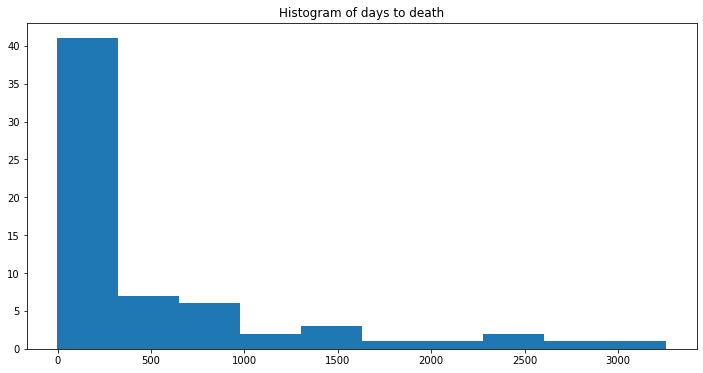

In [451]:
f = plt.figure(figsize=(12,6))
plt.hist(clinpat.loc[2:,'death_days_to'], bins=10);
plt.title('Histogram of days to death');

In [452]:
# Add new deceased variables
mortality = clinpat.loc[2:,['death_days_to','bcr_patient_barcode']]

mortality['deceased'] = mortality['death_days_to'].apply(lambda x: 1 if x > 0 else 0)

mortality['deceased_1yr'] = mortality['death_days_to'].apply(lambda x: 1 if x <= 365 else 0)
mortality['deceased_3yr'] = mortality['death_days_to'].apply(lambda x: 1 if x <= 1095 else 0)
mortality['deceased_5yr'] = mortality['death_days_to'].apply(lambda x: 1 if x <= 1825 else 0)

# Looking for differentially expressed gene between clinical conditions

## R-log transformation

https://bioconductor.org/help/course-materials/2017/CSAMA/labs/2-tuesday/lab-03-rnaseq/rnaseqGene_CSAMA2017.html

Many common statistical methods for exploratory analysis of multidimensional data, for example clustering and principal components analysis (PCA), work best for data that generally has the same range of variance at different ranges of the mean values. When the expected amount of variance is approximately the same across different mean values, the data is said to be homoskedastic. For RNA-seq raw counts, however, the variance grows with the mean. For example, if one performs PCA directly on a matrix of size-factor-normalized read counts, the result typically depends only on the few most strongly expressed genes because they show the largest absolute differences between samples. A simple and often used strategy to avoid this is to take the logarithm of the normalized count values plus a small pseudocount; however, now the genes with the very lowest counts will tend to dominate the results because, due to the strong Poisson noise inherent to small count values, and the fact that the logarithm amplifies differences for the smallest values, these low count genes will show the strongest relative differences between samples.

As a solution, DESeq2 offers transformations for count data that stabilize the variance across the mean. One such transformation is the regularized-logarithm transformation or rlog 2. For genes with high counts, the rlog transformation will give similar result to the ordinary log2 transformation of normalized counts. For genes with lower counts, however, the values are shrunken towards the genes’ averages across all samples. Using an empirical Bayesian prior on inter-sample differences in the form of a ridge penalty, the rlog-transformed data then becomes approximately homoskedastic, and can be used directly for computing distances between samples and making PCA plots. Another transformation, the variance stabilizing transformation 17, is discussed alongside the rlog in the DESeq2 vignette.

## PCA Plots
Now we have everything setup, the first thing to do is to generate PCA plots to observe whether the samples cluster as expected: controls with controls, and treatments with treatments.

Another way to visualize sample-to-sample distances is a principal components analysis (PCA). In this ordination method, the data points (here, the samples) are projected onto the 2D plane such that they spread out in the two directions that explain most of the differences (figure below). The x-axis is the direction that separates the data points the most. The values of the samples in this direction are written PC1. The y-axis is a direction (it must be orthogonal to the first direction) that separates the data the second most. The values of the samples in this direction are written PC2. The percent of the total variance that is contained in the direction is printed in the axis label. Note that these percentages do not add to 100%, because there are more dimensions that contain the remaining variance (although each of these remaining dimensions will explain less than the two that we see).

In [325]:
# Use DESEQ2 R library to rlog transform

from rpy2.robjects.packages import importr
deseq = importr('DESeq2')

In [375]:
from rpy2.robjects import pandas2ri, Formula
pandas2ri.activate()

In [461]:
pd.DataFrame({'id': ['geneA', 'geneB', 'geneC'], 'sampleA1': [5,4,1], 'sampleA2': [5,4,1], 'sampleB1': [1,5,2], 'sampleB2': [1,5,2]})

,id,sampleA,sampleB
0,geneA,5,1
1,geneB,4,5
2,geneC,1,2


In [462]:
pd.DataFrame({'samplename': ['sampleA1', 'sampleA2', 'sampleB1', 'sampleB2'], 'treatment': ['A','A','B','B']})

,samplename,treatment
0,sampleA1,A
1,sampleA2,A
2,sampleB1,B
3,sampleB2,B


In [464]:
# binary matrix of group that the row belongs to
design_formula

R object with classes: ('formula',) mapped to:

## NICK to create wrapper in python for DEseq2

In [465]:
# Create DESeq dataset

'''
DESeq2 object through rpy2
    input:
    count_matrix: should be a pandas dataframe with each column as count, and a id column for gene id
        example:
        id    sampleA    sampleB
        geneA    5    1
        geneB    4    5
        geneC    1    2
    design_matrix: an design matrix in the form of pandas dataframe, see DESeq2 manual, samplenames as rownames
                treatment
    sampleA1        A
    sampleA2        A
    sampleB1        B
    sampleB2        B
    design_formula: see DESeq2 manual, example: "~ treatment""
    gene_column: column name of gene id columns, example "id"

'''

count_matrix = pd.DataFrame({'id': ['geneA', 'geneB', 'geneC'], 'sampleA1': [5,4,1], 'sampleA2': [5,4,1], 'sampleB1': [1,5,2], 'sampleB2': [1,5,2]})
design_matrix = pd.DataFrame({'samplename': ['sampleA1', 'sampleA2', 'sampleB1', 'sampleB2'], 'treatment': ['A','A','B','B']})

with localconverter(ro.default_converter + pandas2ri.converter):
    count_matrix = ro.conversion.py2rpy(count_matrix.set_index('id'))
    design_matrix = ro.conversion.py2rpy(design_matrix.set_index('samplename'))

# count_matrix = pandas2ri.py2ri(count_matrix)
# design_matrix = pandas2ri.py2ri(lihc_processed['tumor_grade'])
design_formula = Formula("~ treatment")
        
dds = deseq.DESeqDataSetFromMatrix(countData=count_matrix,
                                        colData=design_matrix,
                                        design=design_formula)

deseq.rlog(dds,blind=False)

R[write to console]: Error in estimateDispersionsFit(object, fitType, quiet = TRUE) : 
  all gene-wise dispersion estimates are within 2 orders of magnitude
  from the minimum value, and so the standard curve fitting techniques will not work.
  One can instead use the gene-wise estimates as final estimates:
  dds <- estimateDispersionsGeneEst(dds)
  dispersions(dds) <- mcols(dds)$dispGeneEst
  ...then continue with testing using nbinomWaldTest or nbinomLRT
Calls: <Anonymous> -> estimateDispersionsFit

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In DESeqDataSet(se, design = design, ignoreRank) :
R[write to console]: 
 
R[write to console]:  some variables in design formula are characters, converting to factors



RRuntimeError: Error in estimateDispersionsFit(object, fitType, quiet = TRUE) : 
  all gene-wise dispersion estimates are within 2 orders of magnitude
  from the minimum value, and so the standard curve fitting techniques will not work.
  One can instead use the gene-wise estimates as final estimates:
  dds <- estimateDispersionsGeneEst(dds)
  dispersions(dds) <- mcols(dds)$dispGeneEst
  ...then continue with testing using nbinomWaldTest or nbinomLRT
Calls: <Anonymous> -> estimateDispersionsFit


In [466]:
dds

R object with classes: ('DESeqDataSet',) mapped to:

In [407]:
# Create DESeq dataset

'''
DESeq2 object through rpy2
    input:
    count_matrix: should be a pandas dataframe with each column as count, and a id column for gene id
        example:
        id    sampleA    sampleB
        geneA    5    1
        geneB    4    5
        geneC    1    2
    design_matrix: an design matrix in the form of pandas dataframe, see DESeq2 manual, samplenames as rownames
                treatment
    sampleA1        A
    sampleA2        A
    sampleB1        B
    sampleB2        B
    design_formula: see DESeq2 manual, example: "~ treatment""
    gene_column: column name of gene id columns, example "id"

'''

with localconverter(ro.default_converter + pandas2ri.converter):
    count_matrix = lihc_processed.reset_index().drop(['tumor_grade'], axis=1).T
    count_matrix = ro.conversion.py2rpy(count_matrix.reset_index(drop=True))
    design_matrix = ro.conversion.py2rpy(lihc_processed['tumor_grade'].reset_index(drop=True))

# count_matrix = pandas2ri.py2ri(count_matrix)
# design_matrix = pandas2ri.py2ri(lihc_processed['tumor_grade'])
design_formula = Formula("~ treatment")
        
dds = deseq.DESeqDataSetFromMatrix(countData=count_matrix,
                                        colData=design_matrix,
                                        design=design_formula)

deseq.rlog(dds,blind=False)

/Users/mattheweng/Desktop/Galvanize/Projects/hacknights/env-tcga/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:60: UserWarning: Error while trying to convert the column "0". Fall back to string conversion. The error is: Series can only be of one type, or None.
  % (name, str(e)))


AttributeError: 'float' object has no attribute 'encode'

In [396]:
lihc_processed['tumor_grade'].reset_index(drop=True)

0     G3
1     G3
2     G3
3     G2
4     G2
      ..
87    G2
88    G1
89    G3
90    G3
91    G1
Name: tumor_grade, Length: 92, dtype: object

In [406]:
count_matrix = lihc_processed.reset_index().drop(['tumor_grade'], axis=1).T
count_matrix.reset_index(drop=True)

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
0,4073,A10W,A10W,A10X,A10X,A10Y,A10Y,A10Z,A10Z,A110,...,A4NN,A4NO,A4NP,A4NQ,A4NR,A4NS,A4NV,A5W4,A69H,A69I
1,32.022,186.426,18.8844,163.985,268.089,244.851,48.2907,185.821,34.0774,62.2372,...,32.811,48.6618,81.6327,84.3673,52.5176,342.282,57.0324,35.6486,12506.6,42.4645
2,1742.45,390.894,1219.34,324.876,598.55,998.474,1978.96,333.582,1967.86,227.923,...,2280.12,3627.74,385.9,617.534,1362.21,1207.54,5304.01,2179.54,897.81,595.261
3,487.649,268.041,178.106,563.119,560.252,360.031,461.87,170.895,1300.55,266.611,...,441.724,306.569,150.013,472.283,844.072,196.696,159.981,250.369,262.774,226.73
4,2077.31,1195.88,1268.22,1310.64,1238.68,1904.65,1061.92,932.836,1595.17,742.641,...,743.879,1215.33,1030.48,819.319,1144.02,1516.78,962.784,547.165,667.153,803.033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17176,663.769,414.949,269.935,613.861,568.458,544.622,531.676,707.463,1291.49,365.854,...,397.649,373.479,791.413,634.059,1095.83,438.823,621.073,1427.6,459.854,932.701
17177,564.044,268.9,139.596,345.916,277.937,456.903,581.879,438.806,421.87,310.345,...,295.299,264.599,542.804,273.106,443.422,287.042,410.827,508.2,636.496,498.957
17178,222.324,207.904,352.138,290.842,200.793,510.298,235.716,126.866,472.77,96.7199,...,133.203,324.209,268.222,159.167,216.026,374.806,594.007,156.688,51.0949,142.559
17179,111.619,29.2096,106.641,25.3713,10.9424,16.0183,0.4781,124.627,0,10.9336,...,1.4691,1.2165,1.0602,59.1441,64.4288,94.476,1.45,23.2131,10.219,1.5166


In [377]:
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter

In [378]:
with localconverter(ro.default_converter + pandas2ri.converter):
    r_from_pd_df = ro.conversion.py2rpy(lihc.head())
r_from_pd_df

X..100130426,X..100133144,X..100134869,...,ZZZ3.26009,psiTPTE22.387590,tAKR.389932
...,...,...,...,...,...,...


In [372]:
lihc_processed.drop('tumor_grade', axis=1).T

,4073,A10W,A10W,A10X,A10X,A10Y,A10Y,A10Z,A10Z,A110,...,A4NN,A4NO,A4NP,A4NQ,A4NR,A4NS,A4NV,A5W4,A69H,A69I
CDKN1C,32.0220,186.4261,18.8844,163.9851,268.0892,244.8513,48.2907,185.8209,34.0774,62.2372,...,32.8110,48.6618,81.6327,84.3673,52.5176,342.2819,57.0324,35.6486,12506.5693,42.4645
KLF13,1742.4520,390.8935,1219.3383,324.8762,598.5501,998.4744,1978.9625,333.5821,1967.8637,227.9226,...,2280.1175,3627.7372,385.8998,617.5336,1362.2090,1207.5374,5304.0116,2179.5406,897.8102,595.2607
MPV17L,487.6487,268.0412,178.1056,563.1188,560.2517,360.0305,461.8695,170.8955,1300.5500,266.6106,...,441.7238,306.5693,150.0133,472.2827,844.0715,196.6959,159.9807,250.3694,262.7737,226.7299
MARF1,2077.3102,1195.8763,1268.2156,1310.6436,1238.6814,1904.6529,1061.9173,932.8358,1595.1688,742.6409,...,743.8786,1215.3285,1030.4797,819.3192,1144.0173,1516.7785,962.7840,547.1650,667.1533,803.0332
CNOT3,865.5078,457.9038,839.0588,532.7970,589.7962,558.3524,658.8573,632.0896,941.6586,632.4643,...,1544.0744,781.0219,621.2563,1290.7322,809.4207,1020.1342,1011.5998,849.7638,1502.1898,649.8578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SESN2,663.7694,414.9485,269.9355,613.8614,568.4585,544.6224,531.6758,707.4627,1291.4914,365.8537,...,397.6494,373.4793,791.4127,634.0592,1095.8311,438.8229,621.0730,1427.6032,459.8540,932.7014
MED18,564.0439,268.9003,139.5963,345.9158,277.9374,456.9031,581.8790,438.8060,421.8699,310.3448,...,295.2987,264.5985,542.8041,273.1064,443.4218,287.0418,410.8265,508.2002,636.4964,498.9573
PLEKHM3,222.3239,207.9038,352.1381,290.8416,200.7933,510.2975,235.7160,126.8657,472.7704,96.7199,...,133.2027,324.2092,268.2216,159.1671,216.0260,374.8064,594.0068,156.6882,51.0949,142.5592
C3orf52,111.6194,29.2096,106.6412,25.3713,10.9424,16.0183,0.4781,124.6269,0.0000,10.9336,...,1.4691,1.2165,1.0602,59.1441,64.4288,94.4760,1.4500,23.2131,10.2190,1.5166


In [373]:
lihc_processed['tumor_grade']

4073    G3
A10W    G3
A10W    G3
A10X    G2
A10X    G2
        ..
A4NS    G2
A4NV    G1
A5W4    G3
A69H    G3
A69I    G1
Name: tumor_grade, Length: 92, dtype: object

## Differential Gene Expression
Now we are ready to identify the differentially expressed genes between the two sets of samples: control vs. treatment. We will achieve this using the Characteristic Direction method[6](#ref6) that we developed and published in BMC Bioinformatics in 2014.

An implementation in Python of the Characteristic Direction method can be downloaded and installed from here: https://github.com/wangz10/geode.
    


In [414]:
import src.geode

In [ ]:
import geode
d_platform_cd = {} # to top up/down genes
cd_results = pd.DataFrame(index=expr_df.index)

sample_classes = {}
for layout in meta_df['LibraryLayout_s'].unique():
    ## make sample_class 
    sample_class = np.zeros(expr_df.shape[1], dtype=np.int32)
    sample_class[meta_df['LibraryLayout_s'].values == layout] = 1
    sample_class[(meta_df['LibraryLayout_s'].values == layout) & 
                 (meta_df['infection_status_s'].values == 'Zika infected')] = 2
    platform = d_layout_platform[layout]
    sample_classes[platform] = sample_class

sample_classes['combined'] = sample_classes['MiSeq'] + sample_classes['NextSeq 500']
print sample_classes

for platform, sample_class in sample_classes.items():
    cd_res = geode.chdir(expr_df.values, sample_class, expr_df.index, 
                      gamma=.5, sort=False, calculate_sig=False)
    cd_coefs = np.array(map(lambda x: x[0], cd_res))
    cd_results[platform] = cd_coefs
    
    # sort CD in by absolute values in descending order
    srt_idx = np.abs(cd_coefs).argsort()[::-1]
    cd_coefs = cd_coefs[srt_idx][:600]
    sorted_DEGs = expr_df.index[srt_idx][:600]
    # split up and down
    up_genes = dict(zip(sorted_DEGs[cd_coefs > 0], cd_coefs[cd_coefs > 0]))
    dn_genes = dict(zip(sorted_DEGs[cd_coefs < 0], cd_coefs[cd_coefs < 0]))
    d_platform_cd[platform+'-up'] = up_genes
    d_platform_cd[platform+'-dn'] = dn_genes

print cd_results.head()

In [ ]:
## Check the cosine distance between the two signatures
from scipy.spatial.distance import cosine
from itertools import combinations
for col1, col2 in combinations(cd_results.columns, 2):
    print col1, col2, cosine(cd_results[col1], cd_results[col2])

In [ ]:
# EXTRA: DELETE  later

## Prepare count matrices
expect input data as obtained, e.g., from RNA-seq or another high-throughput sequencing experiment, in the form of a matrix of integer values. The value in the i-th row and the j-th column of the matrix tells how many reads (or fragments, for paired-end RNA-seq) have been assigned to gene i in sample j. Analogously, for other types of assays, the rows of the matrix might correspond e.g., to binding regions (with ChIP-Seq), species of bacteria (with metagenomic datasets), or peptide sequences (with quantitative mass spectrometry).

The values in the matrix should be counts of sequencing reads/fragments. This is important for DESeq2’s statistical model to hold, as only counts allow assessing the measurement precision correctly. It is important to never provide counts that were pre-normalized for sequencing depth/library size, as the statistical model is most powerful when applied to un-normalized counts, and is designed to account for library size differences internally.

## Align Reads to reference genome
The computational analysis of an RNA-seq experiment begins from the FASTQ files that contain the nucleotide sequence of each read and a quality score at each position. These reads must first be aligned to a reference genome or transcriptome, or the abundances and estimated counts per transcript can be estimated without alignment, as described above. In either case, it is important to know if the sequencing experiment was single-end or paired-end, as the alignment software will require the user to specify both FASTQ files for a paired-end experiment. The output of this alignment step is commonly stored in a file format called SAM/BAM.


## Define gene models

## Plot counts

## PCA Plot 

## Differential Expression Analysis
## Gene Clustering





In [ ]:
from diffexp.py_deseq import py_DESeq2

dds = py_DESeq2(count_matrix = df,
               design_matrix = sample_df,
               design_formula = '~ sample',
               gene_column = 'id') # <- telling DESeq2 this should be the gene ID column
    
dds.run_deseq() 
dds.get_deseq_result()
res = dds.deseq_result 
res.head()

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(res.log2FoldChange, -np.log2(res.padj))

In [2]:
from dgeclust import CountData, SimulationManager

ModuleNotFoundError: No module named 'dgeclust'